In [1]:
import gmsh
import meshio
from nodes import Node
from elements import CST
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation

import gmsh
import meshio
from nodes import Node
from elements import CST

def load_mesh_objects(geo_file="geo.geo", msh_file="mesh.msh"):
    gmsh.initialize()
    gmsh.open(geo_file)
    gmsh.model.mesh.generate(2)
    gmsh.write(msh_file)
    gmsh.finalize()

    # Leer malla
    mesh = meshio.read(msh_file)

    # Crear nodos
    nodes = [Node(i, x, y) for i, (x, y, _) in enumerate(mesh.points)]

    # Crear elementos CST
    cst_elements = []
    for cell_block in mesh.cells:
        if cell_block.type == "triangle":
            for i, node_ids in enumerate(cell_block.data):
                cst_elements.append(CST(i , list(node_ids)))
            break

    # Detectar nodos en líneas físicas ("Diritchlet 1" a "Diritchlet 4")
    boundary_nodes = {1: set(), 2: set(), 3: set(), 4: set()}

    for i, cell_block in enumerate(mesh.cells):
        if cell_block.type == "line":
            physical_ids = mesh.cell_data_dict['gmsh:physical']['line']
            for line, phys_id in zip(cell_block.data, physical_ids):
                if phys_id in boundary_nodes:
                    for node_id in line:
                        boundary_nodes[phys_id].add(int(node_id))

    # Añadir etiquetas de borde a los nodos
    for node in nodes:
        node.boundary_label = []
        for label_id, node_set in boundary_nodes.items():
            if node.id in node_set:
                node.boundary_label.append(f"Diritchlet Boundary")

    return nodes, cst_elements


def plot_mesh(nodes, elements, show_node_ids=False, show_elem_ids=False):
    x = np.array([node.x for node in nodes])
    y = np.array([node.y for node in nodes])

    # Convertir elementos CST a array de conectividades
    triangles = np.array([elem.node_ids for elem in elements])

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect('equal')

    triang = Triangulation(x, y, triangles)
    ax.triplot(triang, color='gray', linewidth=0.8)

    if show_node_ids:
        for node in nodes:
            ax.text(node.x, node.y, str(node.id), color='blue', fontsize=8, ha='center', va='center')

    if show_elem_ids:
        for elem in elements:
            coords = np.array([[nodes[j].x, nodes[j].y] for j in elem.node_ids])
            centroid = coords.mean(axis=0)
            ax.text(*centroid, str(elem.id), color='red', fontsize=8, ha='center')

    ax.set_title("Malla de elementos triangulares (CST)")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    plt.tight_layout()
    plt.show()


Info    : Reading 'geo.geo'...
Info    : Done reading 'geo.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000367833s, CPU 0.000385s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Transfinite)
Info    : Done meshing 2D (Wall 9.625e-05s, CPU 0.000101s)
Info    : 100 nodes 202 elements
Info    : Writing 'mesh.msh'...
Info    : Done writing 'mesh.msh'



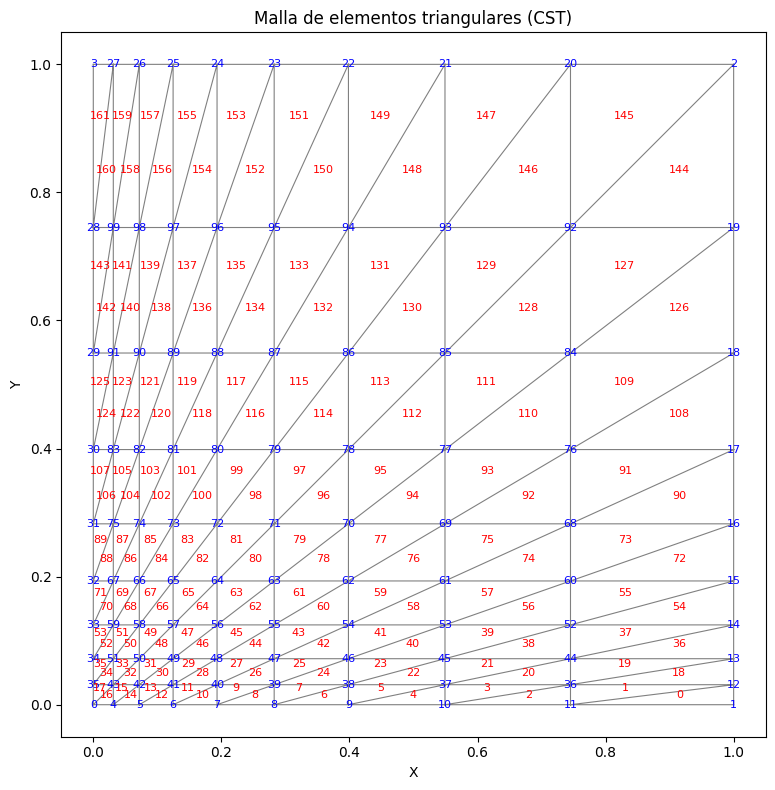

In [2]:
nodes, elements = load_mesh_objects("geo.geo", "mesh.msh")
plot_mesh(nodes, elements, show_node_ids=True, show_elem_ids=True)


In [3]:
#Ahora debo calcular la solucion u

alpha = 0.1

for node in nodes:
    node.solve_u(alpha)

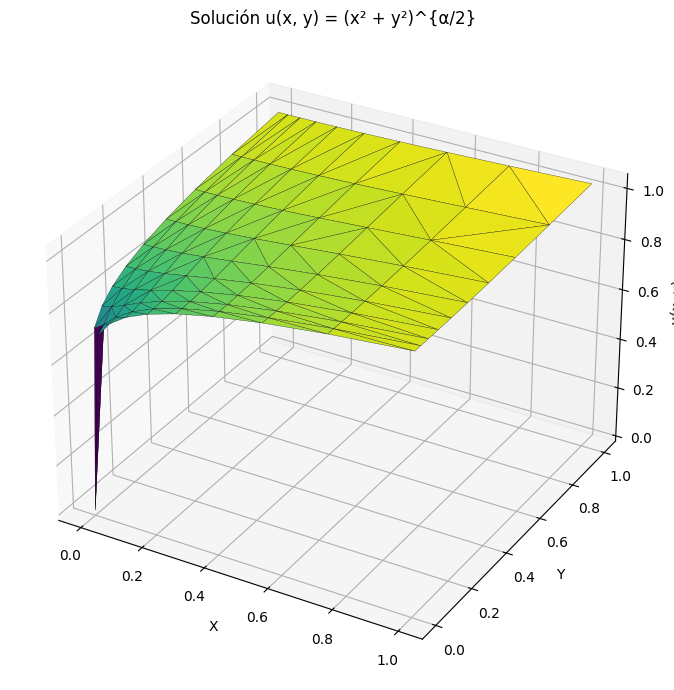

In [4]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

def plot_u_surface(nodes):
    """
    Grafica la superficie u(x, y) usando nodos con atributo u.
    """
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Extraer coordenadas y valores de u
    x = np.array([node.x for node in nodes])
    y = np.array([node.y for node in nodes])
    z = np.array([node.u for node in nodes])

    ax.plot_trisurf(x, y, z, cmap='viridis', edgecolor='k', linewidth=0.2)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("u(x, y)")
    ax.set_title("Solución u(x, y) = (x² + y²)^{α/2}")

    plt.tight_layout()
    plt.show()


# Graficar superficie
plot_u_surface(nodes)

In [5]:
#Bien, ahora es nesesario ensamblar la stifnes matrix de cada elemento CST
from solve import Solve

Estructure = Solve(nodes, elements, alpha)



In [6]:
#Bien, ahora es nesesario calcular la solucion,
#Conozco todos lo que esta en la frontera diritchlet
Estructure.solve_matrix()



array([0.        , 1.        , 1.03526492, 1.        , 0.70707365,
       0.76848861, 0.81201106, 0.84842345, 0.88124443, 0.91208687,
       0.94183224, 0.97101847, 1.00004876, 1.00025743, 1.00077095,
       1.001835  , 1.00384553, 1.00739446, 1.01326802, 1.02233   ,
       1.02233   , 1.01326802, 1.00739446, 1.00384553, 1.001835  ,
       1.00077095, 1.00025743, 1.00004876, 0.97101847, 0.94183224,
       0.91208687, 0.88124443, 0.84842345, 0.81201106, 0.76848861,
       0.70707365, 0.97128063, 0.9422964 , 0.91283215, 0.8824486 ,
       0.850491  , 0.81602822, 0.77812963, 0.73796756, 0.97184775,
       0.94329982, 0.91452888, 0.88538229, 0.85583978, 0.82643431,
       0.79913167, 0.77812963, 0.97295855, 0.94524654, 0.9178526 ,
       0.89111427, 0.86583391, 0.84356457, 0.82643431, 0.81602822,
       0.97499837, 0.94874575, 0.92369947, 0.90071076, 0.88099776,
       0.86583391, 0.85583978, 0.850491  , 0.97854401, 0.95460148,
       0.9329947 , 0.91474725, 0.90071076, 0.89111427, 0.88538

In [7]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_interactive_surface_3d(nodes):
    x = np.array([node.x for node in nodes])
    y = np.array([node.y for node in nodes])
    u_num = np.array([node.u_fem for node in nodes])
    u_ref = np.array([node.u for node in nodes])
    eps = 1e-14
    error_rel = np.abs(u_num - u_ref) / (np.abs(u_ref) + eps)

    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_trisurf(x, y, error_rel, cmap='plasma', edgecolor='k', linewidth=0.2)

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('Error relativo')
    ax.set_title('Error relativo nodal entre u FEM y u exacto')

    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
    plt.show()


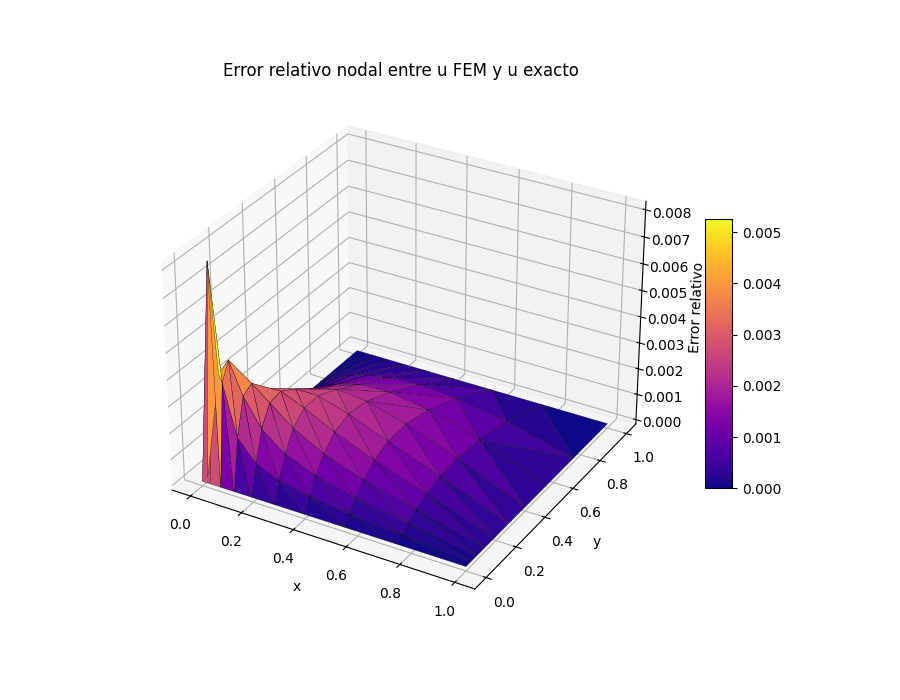

In [8]:
plot_interactive_surface_3d(nodes)
